# Fun with convolutions on 2D toy tracking data

Let's do some exploratory stuff to see what CNNs are capable of on 2D toy detector tracking data.

Some ideas to try:
* autoencoder model which recontructs an entire event
* visualize what the autoencoder learns
* regress on number of tracks
* map pixels to binned track parameter space (hough histogram)
* removing noise hits

In [23]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
from keras import models, layers
from keras.utils import np_utils

# Local imports
from data import (simulate_straight_track,
                  generate_straight_tracks,
                  generate_uniform_noise)
from drawing import (draw_2d_event, draw_2d_input_and_pred,
                     draw_train_history)

from matplotlib import pyplot as plt
%matplotlib notebook

## Utilities

In [2]:
def draw_filters(w, nrows=1, ncols=4, figsize=(9,3)):
    plt.figure(figsize=figsize)
    for i in range(w.shape[0]):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(w[i].T, origin='lower', interpolation='none', cmap='coolwarm')
        plt.axis('off')

def ntrk_to_vector(ntrk, max_tracks):
    """Convert array of track counts to array of categorical vectors"""
    nevt = ntrk.shape[0]
    y = np.zeros((nevt, max_tracks+1))
    y[np.arange(nevt), ntrk] = 1
    return y

def vector_to_ntrk(v):
    """Inverse of ntrk_to_vector"""
    return np.argmax(v, axis=1)

def sample_num_tracks(num_event, max_tracks, avg_num_tracks=None):
    """Draw random track counts, poisson or uniform"""
    if avg_num_tracks is not None:
        num_tracks = np.random.poisson(avg_num_tracks, num_event)
        num_tracks[num_tracks>max_tracks] = max_tracks
    else:
        num_tracks = np.random.randint(max_tracks+1, size=num_event)
    return num_tracks

## Convolutional auto-encoder model

Normally when I'm doing single track finding with these kinds of models, I can impose some constraints such as unitarity on each layer. However, I cannot do that in this case. Let's just enforce that all pixel values fall between 0 and 1 with a sigmoid activation and binary cross entropy loss.

In [85]:
def build_convae_model(det_shape):
    inputs = layers.Input(shape=det_shape)
    # Reshape to add a channel dimension to the input
    hidden = layers.Reshape((1,) + det_shape)(inputs)

    # Encoder
    conv_args = dict(border_mode='same', activation='relu')
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D(pool_size=(2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D(pool_size=(2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(32, 3, 3, **conv_args)(hidden)
    
    # Decoder
    hidden = layers.Conv2D(32, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D(size=(2, 2))(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D(size=(2, 2))(hidden)
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    
    # Final conv with sigmoid
    hidden = layers.Conv2D(1, 3, 3, border_mode='same', activation='sigmoid')(hidden)
    outputs = layers.Reshape(det_shape)(hidden)
    
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='binary_crossentropy',
                  optimizer='Nadam', metrics=['accuracy'])
    return model

In [18]:
def build_convae_model_2(det_shape):
    """Try to decrease the size of the bottleneck in this one"""
    inputs = layers.Input(shape=det_shape)
    # Reshape to add a channel dimension to the input
    hidden = layers.Reshape((1,) + det_shape)(inputs)

    # Encoder
    conv_args = dict(border_mode='same', activation='relu')
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D(pool_size=(2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D(pool_size=(2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D(pool_size=(2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)

    # Decoder
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D(size=(2, 2))(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D(size=(2, 2))(hidden)
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D(size=(2, 2))(hidden)
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    
    # Final conv with sigmoid
    hidden = layers.Conv2D(1, 3, 3, border_mode='same', activation='sigmoid')(hidden)
    outputs = layers.Reshape(det_shape)(hidden)
    
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='binary_crossentropy',
                  optimizer='Nadam', metrics=['accuracy'])
    return model

In [19]:
# Batch generator function
def batch_generator_convae(num_event, det_shape, num_tracks, binary=True):
    """
    Generator function for batches of toy data for training.
    This function generates a fixed number of tracks in a batch.
    """
    while True:
        events = sum(generate_straight_tracks(num_event, det_shape)
                     for i in range(num_tracks))
        if binary:
            events[events > 1] = 1
        # Input and target are the same here
        yield events, events

### Training

In [66]:
# Detector configuration
det_shape = (det_width, det_depth) = (64, 64)

# Data configuration
num_tracks = 8

# Training config
batch_size = 64
events_per_epoch = 102400
num_epoch = 100

In [67]:
model1 = build_convae_model_2(det_shape)
model1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 64, 64)        0                                            
____________________________________________________________________________________________________
reshape_13 (Reshape)             (None, 1, 64, 64)     0           input_7[0][0]                    
____________________________________________________________________________________________________
convolution2d_69 (Convolution2D) (None, 8, 64, 64)     80          reshape_13[0][0]                 
____________________________________________________________________________________________________
convolution2d_70 (Convolution2D) (None, 8, 64, 64)     584         convolution2d_69[0][0]           
___________________________________________________________________________________________

In [ ]:
batcher = batch_generator_convae(batch_size, det_shape, num_tracks)
history1 = model1.fit_generator(
    batcher, samples_per_epoch=events_per_epoch, nb_epoch=num_epoch)

Epoch 1/100
102400/102400 [==============================] - 127s - loss: 0.2243 - acc: 0.8956   
Epoch 2/100
102400/102400 [==============================] - 126s - loss: 0.1726 - acc: 0.9159   
Epoch 3/100
102400/102400 [==============================] - 126s - loss: 0.1556 - acc: 0.9248   
Epoch 4/100
102400/102400 [==============================] - 126s - loss: 0.1441 - acc: 0.9307   
Epoch 5/100
102400/102400 [==============================] - 126s - loss: 0.1357 - acc: 0.9348   
Epoch 6/100
102400/102400 [==============================] - 127s - loss: 0.1295 - acc: 0.9378   
Epoch 7/100
102400/102400 [==============================] - 127s - loss: 0.1244 - acc: 0.9403   
Epoch 8/100
102400/102400 [==============================] - 127s - loss: 0.1197 - acc: 0.9425   
Epoch 9/100
102400/102400 [==============================] - 127s - loss: 0.1158 - acc: 0.9443   
Epoch 10/100
102400/102400 [==============================] - 126s - loss: 0.1124 - acc: 0.9460   
Epoch 11/100
102400

<IPython.core.display.Javascript object>


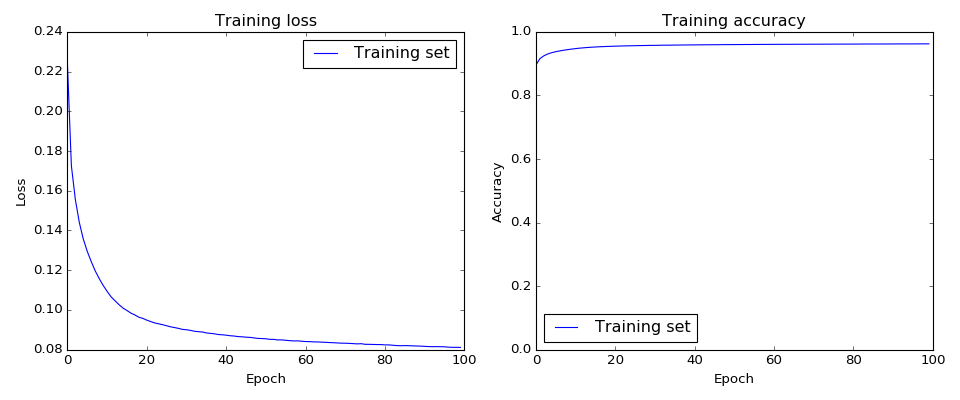

In [69]:
draw_train_history(history1, draw_val=False);

### Test set evaluation

In [70]:
num_test = 16
test_events, test_target = batch_generator_convae(num_test, det_shape, num_tracks).next()
test_pred = model1.predict(test_events)

<IPython.core.display.Javascript object>


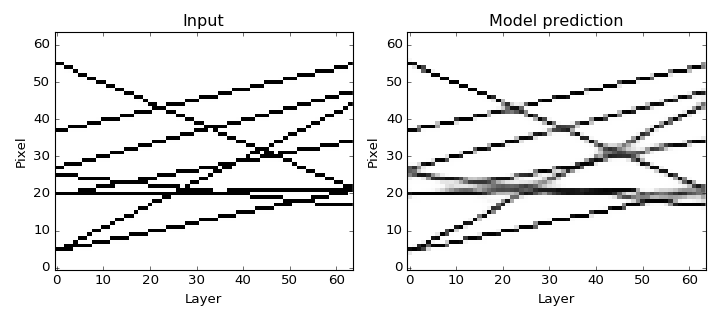

<IPython.core.display.Javascript object>


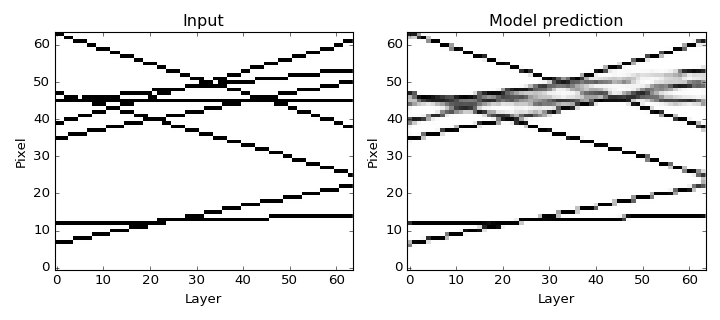

<IPython.core.display.Javascript object>


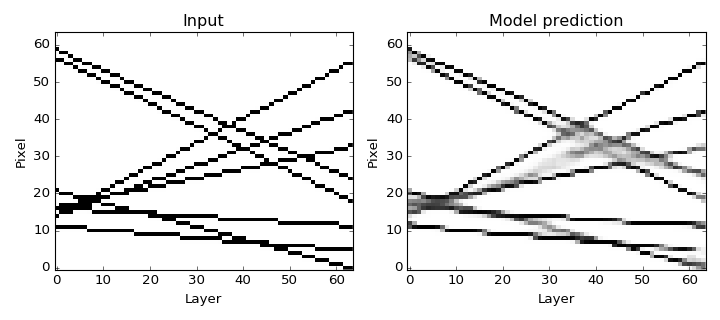

<IPython.core.display.Javascript object>


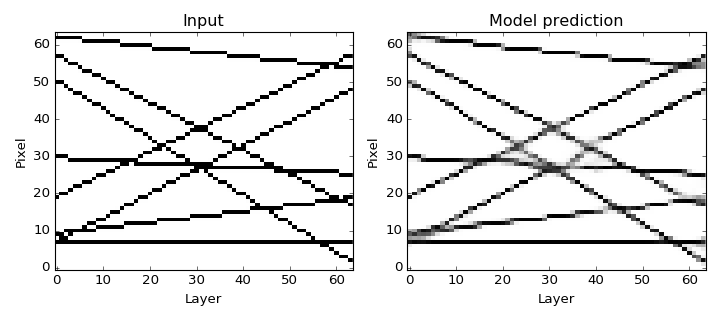

<IPython.core.display.Javascript object>


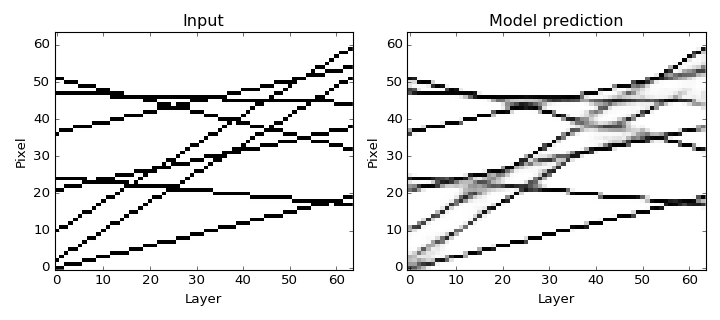

In [72]:
for i in [0, 1, 2, 3, 4]:
    draw_2d_input_and_pred(test_events[i], test_pred[i], cmap='gray_r');

In [75]:
64*64*0.96

3932.16

In [79]:
test_events.sum(axis=2).sum(axis=1).mean()

478.5625

In [83]:
1 - 478. / (64*64)

0.88330078125

<IPython.core.display.Javascript object>


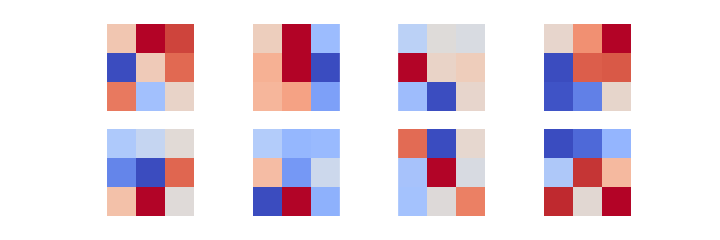

In [73]:
# Draw the first layer filters
all_weights = model1.get_weights()
w0 = np.squeeze(all_weights[0])
draw_filters(w0, nrows=2)

## De-noising auto-encoder

Let's try the above model again with a slight extension, train it to remove the uniform noise hits in its reconstruction of the event.

To do this, we need to update the batch generator and that's pretty much it.

In [324]:
# Batch generator function
def batch_generator_denoiseAE(num_event, det_shape, num_tracks,
                              noise_prob=0.01, binary=True):
    """
    Generator function for batches of toy data for training the de-noising
    auto-encoder. This function generates a fixed number of tracks in a batch.
    """
    while True:
        tracks = sum(generate_straight_tracks(num_event, det_shape)
                     for i in range(num_tracks))
        noise = generate_uniform_noise(num_event, det_shape,
                                       noise_prob, skip_layers=0)
        events = tracks + noise
        if binary:
            tracks[tracks > 1] = 1
            events[events > 1] = 1
        yield events, tracks

In [332]:
# Data configuration
num_tracks = 8
noise_prob = 0.02

# Training config
batch_size = 64
num_event = 1024000
num_epoch = 10
events_per_epoch = num_event / num_epoch

In [333]:
# Build and train the model
model1b = build_convae_model(det_shape)
batcher1b = batch_generator_convae(
    batch_size, det_shape, num_tracks, noise_prob)
history1b = model1b.fit_generator(
    batcher1b, samples_per_epoch=events_per_epoch, nb_epoch=num_epoch)

Epoch 1/10
102400/102400 [==============================] - 82s - loss: 0.0908 - acc: 0.9586    
Epoch 2/10
102400/102400 [==============================] - 82s - loss: 0.0416 - acc: 0.9820    
Epoch 3/10
102400/102400 [==============================] - 82s - loss: 0.0321 - acc: 0.9863    
Epoch 4/10
102400/102400 [==============================] - 82s - loss: 0.0277 - acc: 0.9883    
Epoch 5/10
102400/102400 [==============================] - 82s - loss: 0.0368 - acc: 0.9844    
Epoch 6/10
102400/102400 [==============================] - 82s - loss: 0.0320 - acc: 0.9866    
Epoch 7/10
102400/102400 [==============================] - 82s - loss: 0.0280 - acc: 0.9884    
Epoch 8/10
102400/102400 [==============================] - 82s - loss: 0.0348 - acc: 0.9856    
Epoch 9/10
102400/102400 [==============================] - 82s - loss: 0.0316 - acc: 0.9870    
Epoch 10/10
102400/102400 [==============================] - 82s - loss: 0.0246 - acc: 0.9898    


<IPython.core.display.Javascript object>


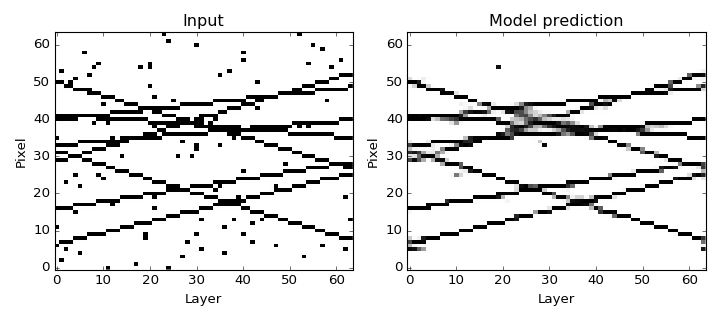

<IPython.core.display.Javascript object>


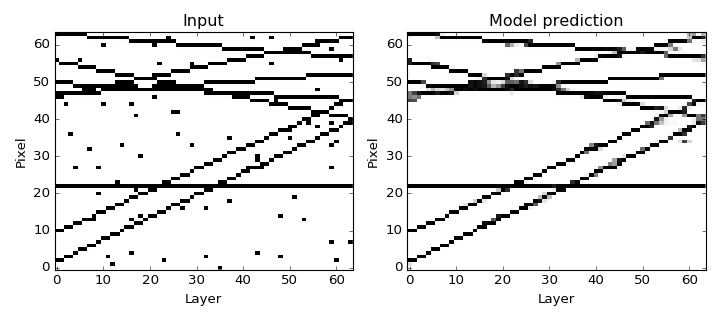

In [334]:
num_test = 2
test1b_events, test1b_target = batch_generator_denoiseAE(
    num_test, det_shape, num_tracks, noise_prob).next()
test1b_pred = model1b.predict(test1b_events)

i = 0
draw_2d_input_and_pred(test1b_events[i], test1b_pred[i], cmap='gray_r');
i = 1
draw_2d_input_and_pred(test1b_events[i], test1b_pred[i], cmap='gray_r');

Nice! It seems to work pretty well, though it gets a little confused still when noise hits are touching tracks or each other.

## Track counting model

Now let's make a model which tells how many tracks are in the event.

What's going to be the best way to format the output? I'm not sure it's possible to get an integer output of a model, though there are some loss functions in keras that should work with integers (e.g. Poisson). Perhaps an easy way to go is to work in a categorical space. I.e., have a class for each track multiplicity and use a maximum cutoff.

In [243]:
def batch_generator_2(num_event, det_shape,
                      max_tracks, avg_num_tracks=None,
                      noise_prob=0, binary=True):
    """
    Generator function for batches of toy data for training.
    if avg_num_tracks is provided, sample random number of tracks
    from a Poisson distribution, otherwise sample uniformly in range.
    """
    while True:
        num_tracks = sample_num_tracks(num_event, max_tracks, avg_num_tracks)
        events = np.zeros((num_event,) + det_shape)
        for ievt in range(num_event):
            events[ievt] = sum(generate_straight_tracks(num_tracks[ievt], det_shape))
        noise = generate_uniform_noise(num_event, det_shape,
                                       noise_prob, skip_layers=0)
        events += noise
        if binary:
            events[events > 1] = 1
        # Convert number of tracks to class categories
        target = ntrk_to_vector(num_tracks, max_tracks)
        yield events, target

def draw_event_ntrk(pred, target, max_tracks):
    idx = np.arange(max_tracks + 1)
    plt.bar(idx, target, label='target', color='red', alpha=0.5)
    plt.bar(idx, pred, label='prediction', color='blue', alpha=0.5)
    plt.xlabel('Number of tracks')
    plt.title('Prediction')
    plt.legend(loc=0)

In [224]:
def build_counting_model(det_shape, max_tracks, optimizer='Adam'):
    """
    Simple conv model which predicts how many tracks are in each event.
    Output is discrete max_tracks channels, optimized as classification.
    Default optimizer is Adam, because bad behavior was observed with Nadam.
    """
    inputs = layers.Input(shape=det_shape)
    # Reshape to add a channel dimension to the input
    hidden = layers.Reshape((1,) + det_shape)(inputs)
    # Convolutions and downsampling
    hidden = layers.Conv2D(8, 3, 3, border_mode='same', activation='relu')(hidden)
    hidden = layers.MaxPooling2D(pool_size=(2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(12, 3, 3, border_mode='same', activation='relu')(hidden)
    hidden = layers.MaxPooling2D(pool_size=(2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(16, 3, 3, border_mode='same', activation='relu')(hidden)
    hidden = layers.MaxPooling2D(pool_size=(2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(20, 3, 3, border_mode='same', activation='relu')(hidden)
    hidden = layers.MaxPooling2D(pool_size=(2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(24, 3, 3, border_mode='same', activation='relu')(hidden)
    # Fully connected and softmax
    hidden = layers.Flatten()(hidden)
    outputs = layers.Dense(max_tracks+1, activation='softmax')(hidden)
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [225]:
# Data config
avg_num_tracks = None
max_tracks = 16
noise_prob = 0

# Training config
batch_size = 64
num_event = 1024000
num_epoch = 10
events_per_epoch = num_event / num_epoch

In [226]:
model2 = build_counting_model(
    det_shape, max_tracks=max_tracks, optimizer='Adam')
model2.summary()

batcher = batch_generator_2(
    batch_size, det_shape, max_tracks=max_tracks,
    avg_num_tracks=avg_num_tracks, noise_prob=noise_prob)
history2 = model2.fit_generator(
    batcher, samples_per_epoch=events_per_epoch, nb_epoch=num_epoch)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 64, 64)        0                                            
____________________________________________________________________________________________________
reshape_12 (Reshape)             (None, 1, 64, 64)     0           input_11[0][0]                   
____________________________________________________________________________________________________
convolution2d_72 (Convolution2D) (None, 8, 64, 64)     80          reshape_12[0][0]                 
____________________________________________________________________________________________________
maxpooling2d_39 (MaxPooling2D)   (None, 8, 32, 32)     0           convolution2d_72[0][0]           
___________________________________________________________________________________________

## Evaluate

In [228]:
num_test2 = 10240
test2_events, test2_target = batch_generator_2(num_test2, det_shape, max_tracks=max_tracks,
                                               avg_num_tracks=avg_num_tracks,
                                               noise_prob=noise_prob).next()
test2_pred = model2.predict(test2_events)

<IPython.core.display.Javascript object>


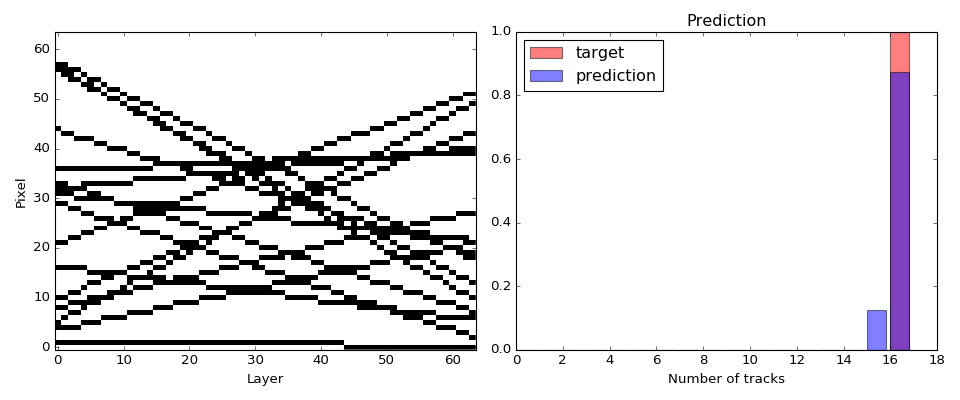

In [240]:
# Plot the event and a bar plot of the prediction.
i = 12
plt.figure(figsize=(12,5))
plt.subplot(121)
draw_2d_event(test2_events[i], cmap='gray_r')
plt.subplot(122)
draw_event_ntrk(test2_pred[i], test2_target[i], max_tracks)
plt.tight_layout()

In [230]:
# Let's quantify how close the prediction is.
# Convert prediction and target to integer values.
test2_ntrk = vector_to_ntrk(test2_target)
test2_ntrk_pred = vector_to_ntrk(test2_pred)
test2_err = test2_ntrk_pred - test2_ntrk

<IPython.core.display.Javascript object>


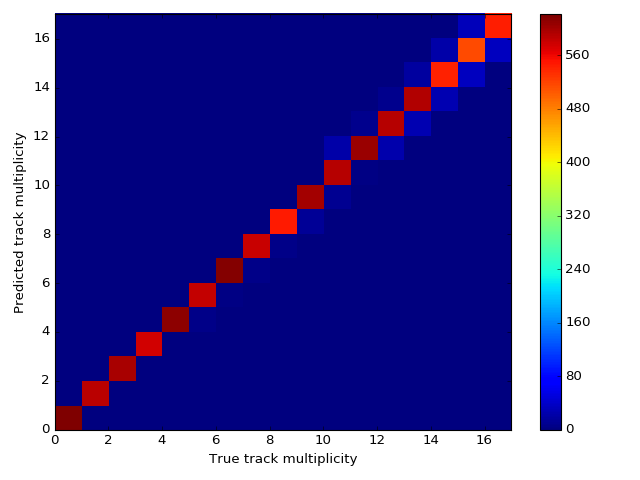

In [232]:
# Plot the true vs predicted multiplicity
plt.figure()
plt.hist2d(test2_ntrk, test2_ntrk_pred, bins=max_tracks+1,
           range=[[0, max_tracks+1],[0, max_tracks+1]])
plt.xlabel('True track multiplicity')
plt.ylabel('Predicted track multiplicity')
plt.colorbar()
plt.tight_layout()

## Track parameter space

Let's make a model which spits out a binned track parameter space. If it works, the output histogram should have peaks where the actual tracks are.

There are multiple ways to format this parameter space:
* Each bin could have an integer (or float) specifying how many tracks are in it.
  * But then how to define the loss? MSE?
* The bins could be normalized as a probability distribution.
  * The model would have to spit out the normalization separately (as done above)
* Each bin could have classes for the number of tracks, like above.
  * Could maybe have just 0, 1, 2+ as classes
  * Or I could maybe just start with binary bins

We will need to update the data generation to give us the track parameters in a binned form.

In [295]:
def generate_tracks_params(n, det_shape):
    """Generates straight tracks and gives track params."""
    # Initialize the data
    det_depth, det_width = det_shape
    data = np.zeros((n, det_depth, det_width))
    # Sample detector entry and exit points
    entry_points = np.random.uniform(0, det_width, size=n)
    exit_points = np.random.uniform(0, det_width, size=n)
    # Calculate track slopes
    slopes = (exit_points - entry_points) / det_depth
    # Simulate detector response and fill the data structure
    for i, (entry, slope) in enumerate(zip(entry_points, slopes)):
        data[i] = simulate_straight_track(slope, entry, det_shape)
    # Format the track parameters
    return data, entry_points, slopes

def param_ranges(det_shape):
    intercept_range = [0, det_shape[1]]
    max_slope = float(det_shape[1]) / det_shape[0]
    slope_range = [-max_slope, max_slope]
    return intercept_range, slope_range

def make_param_hist2d(p0, p1, p0_bins, p1_bins,
                      p0_range, p1_range, binary=True):
    """Construct (binary) 2D histogram of track parameters"""
    h, _, _ = np.histogram2d(p0, p1, bins=[p0_bins, p1_bins],
                             range=[p0_range, p1_range])
    if binary:
        h[h > 1] = 1
    return h

def batch_generator_3(num_event, det_shape,
                      max_tracks, avg_num_tracks=None, noise_prob=0,
                      intercept_bins=16, slope_bins=16,
                      binary=True):
    """
    Generator function for batches of toy data for training.
    Target is a 2D binned representation of the track parameters.
    """
    intercept_range, slope_range = param_ranges(det_shape)
    while True:
        # Initialize data structures
        events = np.zeros((num_event,) + det_shape)
        params = np.zeros((num_event, intercept_bins, slope_bins))
        num_tracks = sample_num_tracks(num_event, max_tracks, avg_num_tracks)
        # Generate each event
        for ievt in range(num_event):
            tracks, intercepts, slopes = generate_tracks_params(num_tracks[ievt], det_shape)
            events[ievt] = sum(tracks)
            params[ievt] = make_param_hist2d(
                intercepts, slopes,
                intercept_bins, slope_bins,
                intercept_range, slope_range)
        noise = generate_uniform_noise(
            num_event, det_shape, noise_prob, skip_layers=0)
        events += noise
        if binary:
            events[events > 1] = 1
        yield events, params

def draw_param_hist(param_hist, p0_range, p1_range):
    plt.imshow(param_hist.T, origin='lower', interpolation='none',
               extent=p0_range+p1_range, aspect='auto')
    plt.xlabel('Track intercept')
    plt.ylabel('Track slope')
    plt.colorbar()
    plt.tight_layout()

In [310]:
def build_param_model(det_shape, intercept_bins, slope_bins,
                      optimizer='Nadam'):
    """Track parameter space predictor model"""
    inputs = layers.Input(shape=det_shape)
    # Reshape to add a channel dimension to the input
    hidden = layers.Reshape((1,) + det_shape)(inputs)
    
    # Convolutions and downsampling
    hidden = layers.Conv2D(8, 3, 3, border_mode='same', activation='relu')(hidden)
    hidden = layers.MaxPooling2D(pool_size=(2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(16, 3, 3, border_mode='same', activation='relu')(hidden)
    hidden = layers.MaxPooling2D(pool_size=(2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(32, 3, 3, border_mode='same', activation='relu')(hidden)
    hidden = layers.MaxPooling2D(pool_size=(2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(64, 3, 3, border_mode='same', activation='relu')(hidden)
    hidden = layers.MaxPooling2D(pool_size=(2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(128, 3, 3, border_mode='same', activation='relu')(hidden)
    hidden = layers.MaxPooling2D(pool_size=(2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(128, 3, 3, border_mode='same', activation='relu')(hidden)

    # Fully connected transformation
    hidden = layers.Flatten()(hidden)
    hidden = layers.Dense(intercept_bins * slope_bins, activation='sigmoid')(hidden)
    outputs = layers.Reshape((intercept_bins, slope_bins))(hidden)

    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [311]:
# Data config
avg_num_tracks = 8
max_tracks = 16
noise_prob = 0
num_intercept_bins = 16
num_slope_bins = 16

# Training config
batch_size = 64
num_event = 1024000
num_epoch = 10
events_per_epoch = num_event / num_epoch

In [312]:
# Build the model
model3 = build_param_model(det_shape, num_intercept_bins, num_slope_bins)
model3.summary()

# Train the model
batcher = batch_generator_3(
    batch_size, det_shape, max_tracks=max_tracks,
    avg_num_tracks=avg_num_tracks, noise_prob=noise_prob,
    intercept_bins=num_intercept_bins, slope_bins=num_slope_bins)
history3 = model3.fit_generator(
    batcher, samples_per_epoch=events_per_epoch, nb_epoch=num_epoch)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_19 (InputLayer)            (None, 64, 64)        0                                            
____________________________________________________________________________________________________
reshape_27 (Reshape)             (None, 1, 64, 64)     0           input_19[0][0]                   
____________________________________________________________________________________________________
convolution2d_118 (Convolution2D (None, 8, 64, 64)     80          reshape_27[0][0]                 
____________________________________________________________________________________________________
maxpooling2d_77 (MaxPooling2D)   (None, 8, 32, 32)     0           convolution2d_118[0][0]          
___________________________________________________________________________________________

### Evaluation

In [313]:
# Generate some test examples
num_test3 = 8
test3_events, test3_target = batch_generator_3(
    num_test3, det_shape, max_tracks=max_tracks,
    avg_num_tracks=avg_num_tracks, noise_prob=noise_prob,
    intercept_bins=num_intercept_bins, slope_bins=num_slope_bins).next()
test3_pred = model3.predict(test3_events)

<IPython.core.display.Javascript object>


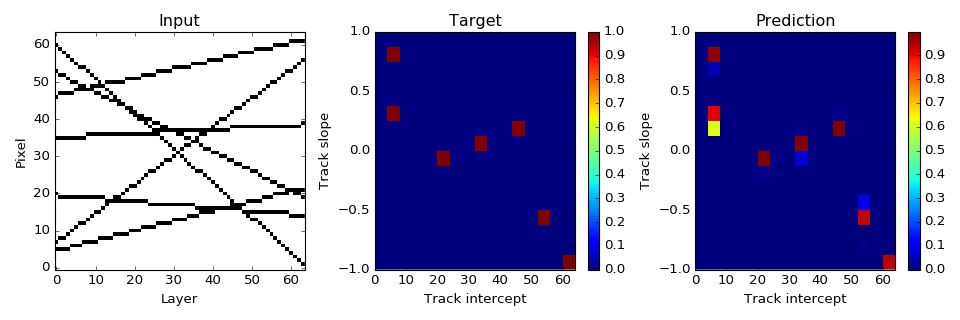

In [338]:
i = 3
plt.figure(figsize=(12,4))
plt.subplot(131)
draw_2d_event(test3_events[i], title='Input', cmap='gray_r')
plt.subplot(132)
intercept_range, slope_range = param_ranges(det_shape)
draw_param_hist(test3_target[i], intercept_range, slope_range)
plt.title('Target')
plt.subplot(133)
draw_param_hist(test3_pred[i], intercept_range, slope_range)
plt.title('Prediction')
plt.tight_layout()

Ok, that kinda works. It could probably be improved a bit. For example, I could use up-sampling+convolution to construct the output param space prediction.